# XGBoost Stratify for Forest Detection

In [1]:
import rasterio
import xarray as xr
import rioxarray as rxr
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import uniform, randint
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import zarr
from dea_tools.bandindices import calculate_indices
from rasterio.warp import reproject, Resampling
import pystac_client
import odc.stac
import os
from scipy.signal import convolve2d
import dask

In [2]:
# Lidar-drived CHMs
lidar_paths = [
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\YA25_1\YF25_1_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\YA25_2\YA25_2_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\YA25_3\YF25_3_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\YA25_4\YF25_4_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\YA25_5\YA25_5_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\20250407_govcowwell\reprocess\20250407_govcowwell_height_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_1\YJ25_1_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_2\YJ25_2_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_3\YJ25_3_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_4\YJ25_4_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_5\YJ25_5_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\YJ25_6\YJ25_6_height_clean_canopy_p98.tif',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Oct_2025\YOct25_1\YOct25_1_height_clean_canopy_p98.tif'
]

In [3]:
# Polygons used to clip edges of CHMs
lidar_polys_paths = [
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\cut_areas\YA25_1_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\cut_areas\YA25_2_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\cut_areas\YA25_3_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\cut_areas\YA25_4_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Apr_2025\cut_areas\YA25_5_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\20250407_govcowwell\LASTools\20250407_govcowwell_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_1_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_2_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_3_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_4_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_5_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_July_2025\cut_areas\YJ25_6_cut_area.gpkg',
    r'G:\Yawuru\Drone Data 2025\Yawuru_Lidar_Oct_2025\cut_areas\YOct25_1_cut_area.gpkg'
]

In [4]:
# PALSAR-2 products
sar_g0_path = r'G:\Yawuru\WCM\SAR\PALSAR 2024 Mosaic\PALSAR_2024_Yawuru_HH_HV_DN_g0_utm_Spk.tif'    # Backscatter
sar_decomp_path = r'G:\Yawuru\WCM\SAR\PALSAR 2024 Mosaic\PolSARPro\PALSAR_2024_Yawuru_HH_HV_s0\PALSAR_2024_Yawuru_HH_HV_s0_Decomp_utm.tif'    # Pdl, Psl, Pu
sar_rbi_path = r'G:\Yawuru\WCM\SAR\PALSAR 2024 Mosaic\PolSARPro\PALSAR_2024_Yawuru_HH_HV_s0\PALSAR_2024_Yawuru_HH_HV_s0_DpRBI_utm.tif'
sar_rsi_path = r'G:\Yawuru\WCM\SAR\PALSAR 2024 Mosaic\PolSARPro\PALSAR_2024_Yawuru_HH_HV_s0\PALSAR_2024_Yawuru_HH_HV_s0_DpRSI_utm.tif'
sar_alpha_path = r'G:\Yawuru\WCM\SAR\PALSAR 2024 Mosaic\PolSARPro\PALSAR_2024_Yawuru_HH_HV_s0\PALSAR_2024_Yawuru_HH_HV_s0_alpha_utm.tif'

In [5]:
# Configure Copernicus STAC for S1 data
os.environ['AWS_S3_ENDPOINT'] = 'eodata.dataspace.copernicus.eu'
os.environ['AWS_ACCESS_KEY_ID'] = 'JM3XK3B6QUIYRTTB44RK'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'jP167ZNV5QsaVLQwR2TxClImqNhs5wT56cHayvBY'
os.environ['AWS_HTTPS'] = 'YES'
os.environ['AWS_VIRTUAL_HOSTING'] = 'FALSE'

# Connect to CDSE STAC
URL = "https://stac.dataspace.copernicus.eu/v1"
catalog = pystac_client.Client.open(URL)
catalog.add_conforms_to("ITEM_SEARCH")

In [6]:
# Load lidar CHM rasters
lidar_rast = [rxr.open_rasterio(f).squeeze() for f in lidar_paths]

# Load clippling polygons
lidar_polys = [gpd.read_file(path).geometry for path in lidar_polys_paths]

## Functions

In [7]:
def raster_align(in_rast, ref_rast, resampling='median', nodata=np.nan):

    """
    Aligns an xarray DataArray raster to a reference raster, using the intersection of their bounds.

    Args:
        in_rast (xarray DataArray): Input raster to align.
        ref_rast (xarray DataArray): Reference raster for alignment and coordinate system.
        resampling (str): Resampling method. One of:
            'nearest', 'bilinear', 'cubic', 'cubic_spline', 'lanczos',
            'average', 'mode', 'max', 'min', 'median', 'q1', 'q3'.
        nodata (float): No-data value to use during reprojection.

    Returns:
        xarray DataArray: Aligned raster, clipped to the intersection of input and reference bounds.
    """

    # Map friendly names to Rasterio's Resampling enum
    resampling_map = {
        'nearest': Resampling.nearest, 'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic, 'cubic_spline': Resampling.cubic_spline,
        'lanczos': Resampling.lanczos, 'average': Resampling.average,
        'mode': Resampling.mode, 'max': Resampling.max, 'min': Resampling.min,
        'median': Resampling.med, 'q1': Resampling.q1, 'q3': Resampling.q3
    }
    resampling_alg = resampling_map.get(resampling.lower())

    if resampling_alg is None:
        print('Wrong resampling algorithm')
        return
    
    # Bounds are tuple (xmin, ymin, xmax, ymax)
    in_bounds = in_rast.rio.bounds()
    ref_bounds = ref_rast.rio.bounds()
    bounds = [0,0,0,0]
    bounds[0] = np.max([in_bounds[0], ref_bounds[0]])
    bounds[1] = np.max([in_bounds[1], ref_bounds[1]])
    bounds[2] = np.min([in_bounds[2], ref_bounds[2]])
    bounds[3] = np.min([in_bounds[3], ref_bounds[3]])

    in_rast_resamp = in_rast.rio.reproject_match(ref_rast, resampling=resampling_alg, nodata=nodata)

    # Set bound
    out_rast = in_rast_resamp.rio.clip_box(minx=bounds[0], miny=bounds[1], maxx=bounds[2], maxy=bounds[3])

    ref_rast_clipped = ref_rast.rio.clip_box(minx=bounds[0], miny=bounds[1], maxx=bounds[2], maxy=bounds[3])
    
    out_rast = out_rast.assign_coords({'x': ref_rast_clipped.x, 'y': ref_rast_clipped.y})

    return out_rast

In [8]:
def classify_raster(rast):

    tree_height = 2.0
    bare_height = 0.2
    
    rast = rast.rio.write_nodata(np.nan)
    valid_mask = ~np.isnan(rast) & (rast != rast.rio.nodata)
       
    classified_rast = xr.where(
        rast >= 2.35,
        3,
        xr.where(
            rast >= 1.22,
            2,  # Value if a pixel is a tree
            xr.where(
                rast >= 0.2,
                1,
                0 
            )
        )
    ).rio.write_crs(rast.rio.crs)
    

    return classified_rast.where(~np.isnan(rast), np.nan)

Open SAR

In [9]:
# Load the SAR rasters and assign band names

sar_g0 = rxr.open_rasterio(sar_g0_path)\
    .sel(band=[3,4])\
    .assign_coords(band=[r'$\gamma^{0}_{HH}$', r'$\gamma^{0}_{HV}$'])
sar_decomp = rxr.open_rasterio(sar_decomp_path).assign_coords(band=['Dihedral', 'Surface', 'Unpolarised'])
sar_rbi = rxr.open_rasterio(sar_rbi_path).assign_coords(band=['DpRBI'])
sar_rsi = rxr.open_rasterio(sar_rsi_path).assign_coords(band=['DpRSI'])
sar_alpha = rxr.open_rasterio(sar_alpha_path).assign_coords(band=[r'$\alpha$'])

C:\Users\glens\miniconda3\envs\general\Lib\site-packages\rioxarray\_io.py:1146: RuntimeWarning: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
  if riods.subdatasets:


In [10]:
# Ensure PALSAR-2 raster grids are aligned and coordinates are identical
sar_g0 = raster_align(sar_g0, sar_decomp, resampling='nearest')
sar_decomp = sar_decomp.assign_coords({'x': sar_g0.x, 'y': sar_g0.y}) 
sar_alpha = sar_alpha.assign_coords({'x': sar_g0.x, 'y': sar_g0.y})
sar_rbi = sar_rbi.assign_coords({'x': sar_g0.x, 'y': sar_g0.y})
sar_rsi = sar_rsi.assign_coords({'x': sar_g0.x, 'y': sar_g0.y})

# Calculate polarisation ratio band
sar_pr = sar_g0.sel(band=r'$\gamma^{0}_{HV}$') / sar_g0.sel(band=r'$\gamma^{0}_{HH}$')
sar_pr = sar_pr.expand_dims(band=['PR'])

In [11]:
# Stack PALSAR-2 bands
sar_data = xr.concat([sar_g0,
                      sar_decomp,
                      sar_alpha,
                      sar_rbi,
                      sar_rsi,
                      sar_pr
                      ], dim='band', join='exact')

Open Sentinel-2 data

In [12]:
# Load Zarr file of Sentinel-2 geomedian
s2 = xr.open_zarr(r'G:\python\odc-stac\ds_median_Yawuru_2025_04.zarr', decode_coords='all')

# Calculate S2 indices
s2 = calculate_indices(s2, index=['NDVI', 'EVI', 'BSI'], collection='ga_s2_3')

# Rename S2 bands
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3', 'NDVI', 'EVI', 'BSI']
band_labels = ['Blue', 'Green', 'Red', 'Red-edge 1', 'Red-edge 2', 'Red-edge 3', 'NIR 1', 'NIR 2', 'SWIR 1', 'SWIR 2', 'NDVI', 'EVI', 'BSI']
s2 = s2.rename(dict(zip(bands, band_labels)))

# Align and clip PALSAR-2 and S2 rasters
s2_aligned = raster_align(s2, sar_data, resampling='nearest')

# Drop SWIR bands
s2_aligned = s2_aligned.drop_vars(['SWIR 1', 'SWIR 2'])

# Updated band name list
band_labels = ['Blue', 'Green', 'Red', 'Red-edge 1', 'Red-edge 2', 'Red-edge 3', 'NIR 1', 'NIR 2', 'NDVI', 'EVI', 'BSI']

In [13]:
# Ensure PALSAR-2 and S2 are properly clipped. Possibly not necessary?
# This does not resample to Sentinel-2 resolution as s2_aligned is already aligned to the SAR resolution.
sar_clipped = sar_data.sel({'x': s2_aligned.x, 'y': s2_aligned.y}, method='nearest').assign_coords({'x': s2_aligned.x, 'y': s2_aligned.y})

## Load S1 data from Copernicus STAC

In [14]:
# Get bounds in EPSG:4326
lon_min, lat_min, lon_max, lat_max = s2_aligned.rio.reproject(dst_crs='epsg:4326').rio.bounds()

In [15]:
# Define AOI as GeoJSON polygon
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [lon_min, lat_min],
        [lon_max, lat_min],
        [lon_max, lat_max],
        [lon_min, lat_max],
        [lon_min, lat_min]
    ]]
}

In [16]:
# Search for July 2024 S1 monthly mosaic
search = catalog.search(
    collections=["sentinel-1-global-mosaics"],
    intersects=aoi,
    datetime="2024-04-01/2024-04-30"
)

In [17]:
# Get list of collection names
collection_ids = [c.id for c in catalog.get_all_collections()]
#print(collection_ids)

In [18]:
items = list(search.items())

In [19]:
# Set to True to download, False to load from stored Zarr file
download_s1 = False

In [20]:
if download_s1 == True:
    s1_ds = odc.stac.load(
        items,
        bands=["VV", "VH"],  # Available polarizations
        geopolygon=aoi,      # Clip to AOI
        resolution=20,       # Native resolution in meters
        crs="EPSG:32751",     # Or appropriate UTM zone
        chunks={"x": 2048, "y": 2048}  # Dask chunking
    )
    s1_ds.to_zarr('s1_april_2025.zarr', mode='w')

s1_da = xr.open_zarr('s1_april_2025.zarr').squeeze().drop_vars('spatial_ref')
s1_band_names = list(s1_da.data_vars)
s1_da = s1_da.to_dataarray(dim='band').assign_coords(band=s1_band_names).rio.write_crs('epsg:32751')

## Perform decomposition

This code adapted from <https://github.com/navv37/Dual-pol-powers>

In [21]:
# From C11_image = spectral.open_image('Sigma0_HH.bin.hdr')
# Use VV as C11 for some reason
C11 = s1_da.sel(band='VV').values
C22 = s1_da.sel(band='VH').values

In [22]:
ws = 5
kernel = np.ones((ws,ws),np.float32)/(ws*ws);
pad = int((ws-1)/2);

In [23]:
C11_av = convolve2d(C11, kernel, mode = 'valid');
C11_av = np.pad(C11_av, pad_width=pad, mode='constant', constant_values=0)
C11_av_db = 10*np.log10(C11_av);

C:\Users\glens\AppData\Local\Temp\ipykernel_10464\982742006.py:3: RuntimeWarning: divide by zero encountered in log10
  C11_av_db = 10*np.log10(C11_av);


In [24]:
C22_av = convolve2d(C22, kernel, mode = 'valid');
C22_av = np.pad(C22_av, pad_width=pad, mode='constant', constant_values=0)

In [25]:
##### Calculating Stokes vector elements
s0 = C11_av + C22_av;
s1 = C11_av - C22_av;

In [26]:
##### Calculate Entropy
## Here eigen values are calculated using Stokes vector elements
prob1 = C11_av/(C11_av + C22_av);
prob2 = C22_av/(C11_av + C22_av);

C:\Users\glens\AppData\Local\Temp\ipykernel_10464\2797853789.py:3: RuntimeWarning: invalid value encountered in divide
  prob1 = C11_av/(C11_av + C22_av);
C:\Users\glens\AppData\Local\Temp\ipykernel_10464\2797853789.py:4: RuntimeWarning: invalid value encountered in divide
  prob2 = C22_av/(C11_av + C22_av);


In [27]:
ent = -prob1*np.log2(prob1) - prob2*np.log2(prob2);

In [28]:
dop = (C11_av - C22_av)/(C11_av + C22_av)
dop = np.abs(dop)
beta = C11_av/(C11_av + C22_av)

C:\Users\glens\AppData\Local\Temp\ipykernel_10464\2003121739.py:1: RuntimeWarning: invalid value encountered in divide
  dop = (C11_av - C22_av)/(C11_av + C22_av)
C:\Users\glens\AppData\Local\Temp\ipykernel_10464\2003121739.py:3: RuntimeWarning: invalid value encountered in divide
  beta = C11_av/(C11_av + C22_av)


In [29]:
##### Taking abs of Stokes vector elements
s0 = np.abs(s0); # Already postive
s1 = np.abs(s1);

In [30]:
# Put this in just in case it's needed.
Slope_msk = np.where(False, 0, 1);

In [31]:
##### Slope mask the Stokes vector elements
C11_mask = np.multiply(C11_av,Slope_msk);
C22_mask = np.multiply(C22_av,Slope_msk);
s1_mask = np.multiply(s1,Slope_msk);

In [32]:
def S_norm(S_array):
    S_5 = np.percentile(S_array, 5)
    S_95 = np.percentile(S_array, 95)
    S_cln = np.where(S_array > S_95, S_95, S_array)
    S_cln = np.where(S_cln < S_5, S_5, S_cln)
    S_cln_max = np.max(S_cln)
    S_norm_array = np.divide(S_cln,S_cln_max) 
    
    return S_norm_array

In [33]:
C11_norm = S_norm(C11_mask)
C22_norm = S_norm(C22_mask)
s1_norm = S_norm(s1_mask)
s1_s_norm = S_norm(s1) #This is S1 normalzied for DpRSI, does not include slope mask

In [34]:
##### Power Calculation

dprbi = np.sqrt(np.square(C11_norm) + np.square(C22_norm))/np.sqrt(2);
dprbi = dprbi*s1_norm;

dprsi_con1 = (1 - ent)*np.sqrt(1 - np.square(s1_s_norm)); # For Valid pixels
dprsi_con2 = np.sqrt(1 - np.square(s1_s_norm)); # For Noise pixels 

NESZ = -16 ## For Sentinel-1
# NESZ = -20 ## For NovaSAR-1
dprsi = np.where(C11_av_db > NESZ, dprsi_con1, dprsi_con2) 

shp = np.shape(dprbi)


alpha1 = np.arctan2(dprbi, 1 - dprbi)
alpha1 = np.degrees(alpha1)

alpha2 = np.arctan2(1-dprsi, dprsi)
alpha2 = np.degrees(alpha2)

alpha_dp = (alpha1 + alpha2)/2; #Dual-pol target characteristic parameter proposed in Verma et al. 2024

In [35]:
## Alpha as geomteric factor
alpha_dp_rad = np.radians(2*alpha_dp) 

cos_a = np.cos(alpha_dp_rad)

## Power components for valid pixels (VV > NESZ)
Pu_v = (1 - dop)*s0 
Pd_v = (1/2)*dop*s0*(1 - cos_a)
Ps_v = (1/2)*dop*s0*(1 + cos_a)

## Power components for noise pixels (VV < NESZ)
Pu_n = (1 - beta)*s0 
Pd_n = (1/2)*beta*s0*(1 - cos_a)
Ps_n = (1/2)*beta*s0*(1 + cos_a)

## Dual-pol scattering power
Pu = np.where(C11_av_db > NESZ, Pu_v, Pu_n) # Unpolized power
Pd = np.where(C11_av_db > NESZ, Pd_v, Pd_n) # "Dihedral-like" power
Ps = np.where(C11_av_db > NESZ, Ps_v, Ps_n) # "Surface-like" power

## Saving the output

dprbi = dprbi.astype(np.float32)
dprsi = dprsi.astype(np.float32)
Pd = Pd.astype(np.float32)
Ps = Ps.astype(np.float32)
Pu = Pu.astype(np.float32)

End of <https://github.com/navv37/Dual-pol-powers>

In [36]:
# Stack S1 decomposition products with S1 backscatter

new_arrays = {
    's1_alpha': alpha_dp,
    's1_DpRBI': dprbi,
    's1_DpRSI': dprsi,
    's1_Pd': Pd,
    's1_Ps': Ps,
    's1_Pu': Pu
}

new_das = [
    xr.DataArray(arr, dims=['y', 'x'], coords={'y': s1_da.y, 'x': s1_da.x}).assign_coords(band=name)
    for name, arr in new_arrays.items()
]

s1_da = xr.concat(
    [s1_da, *new_das],
    dim = 'band'
).assign_coords(band=list(s1_da.band.values) + list(new_arrays.keys()))

In [37]:
# Align S1 stack to PALSAR-2 stack and stack together
s1_da_aligned = raster_align(s1_da, sar_data, resampling='nearest')
s1_clipped = s1_da_aligned.sel({'x': s2_aligned.x, 'y': s2_aligned.y}, method='nearest').assign_coords({'x': s2_aligned.x, 'y': s2_aligned.y})
sar_clipped = xr.concat([sar_clipped, s1_clipped], dim='band', join='exact')

# Lidar Classification

In [38]:
# Mean resampling lidar CHMs to SAR resolution, and clip SAR rasters to lidar CHM rasters
sar_masks = [raster_align(rast, sar_clipped, resampling='average') for rast in lidar_rast]
sar_masks = [classify_raster(r) for r in sar_masks]
sar_masks_clipped = [r.rio.clip(c, drop=True) for r, c in zip(sar_masks, lidar_polys)]

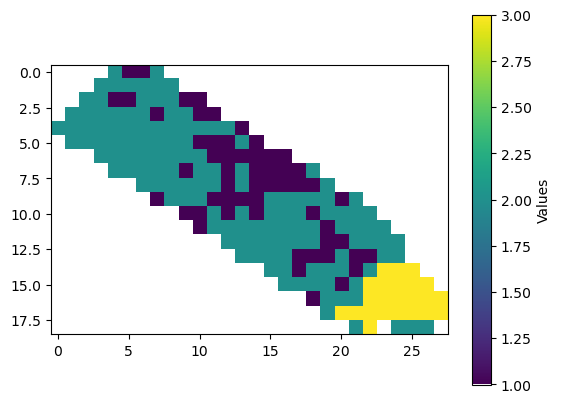

In [39]:
# Test to ensure success
plt.imshow(sar_masks_clipped[4])
plt.colorbar(label='Values')

## Set data sources

In [40]:
# This block is used to change between SAR+2, SAR-only and S2-only stack. Comment/uncomment as necessary

# SAR + S2
data_stack = xr.concat([sar_clipped, s2_aligned.to_dataarray(dim='band').assign_coords({'x': sar_clipped.x, 'y': sar_clipped.y})], dim='band', join='exact')

# SAR only
# data_stack = sar_clipped

# S2 only as this SAR resolution
# data_stack = s2_aligned.to_dataarray(dim='band').assign_coords({'x': sar_clipped.x, 'y': sar_clipped.y})

In [41]:
#Create a list of sections of the `data_stack` clipped to the area of each `sar_mask_clipped`, using the lidar cut area polygons.
data_stack_c = [data_stack.rio.clip(geom, drop=True) for geom in lidar_polys]

## Create feature/predictor stack X

In [42]:
# Stack each element of `data_stack_c` in columns

data_stack_c_cols = np.empty((0, data_stack_c[0].shape[0] + 1))      # Extra col for site number

for idx, d in enumerate(data_stack_c):
    s = d.stack(sample=('y','x')).transpose('sample', 'band').dropna(dim='sample', how='all')
    s = np.hstack([s, np.array([idx]*s.shape[0]).reshape(-1,1)])
    data_stack_c_cols = np.vstack([data_stack_c_cols, s])

In [43]:
# N.B. easting and site number were part of leave-location-out CV and longitudinal stratification.
# Both methods were ultimately excluded due to not enough training data to implement these for a 4-class system.
# The Easting and Site ID columns are exluded when the train-test split is created. (Also Zone column below.)

# Get easting coords of samples
easting = np.array([])
for d in data_stack_c:
    easting = np.hstack([easting, d.stack(sample=('y','x')).transpose('sample', 'band').dropna(dim='sample', how='all').x])
easting = easting.reshape(-1,1)

In [44]:
# Stack features in columns of a dataframe
X = pd.DataFrame(np.hstack([data_stack_c_cols, easting]), columns = list(data_stack.band.values) + ['Site ID', 'Easting'])

In [45]:
# Assign zones by easting/longitude
X['Zone'] = pd.cut(X['Easting'], bins=3, labels = ['West', 'Mid', 'East'])

In [46]:
# Set class labels for 4-class system
class_labels = ['Low vegetation', 'Non-forest', 'Low forest', 'Tall forest']

## Create target stack y

In [47]:
# Stack target values in column of a dataframe
y = [s.values.flatten() for s in sar_masks_clipped]
y = np.hstack(y)
y = y[~np.isnan(y)].astype('int')
y = pd.DataFrame(y, columns=['Target Class'])

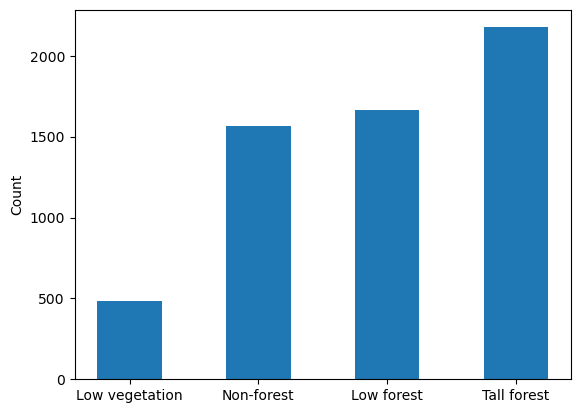

In [48]:
# Class count figure
fig, ax = plt.subplots();
ax.hist(y['Target Class'], bins=[-0.5,0.5,1.5,2.5,3.5], rwidth=0.5);
ax.set_xticks([0,1,2,3]);
ax.set_xticklabels(['Low vegetation','Non-forest','Low forest', 'Tall forest']);
ax.set_ylabel('Count');
# fig.savefig(r'figs4class\4class_frequency.png', dpi=600);

## Create train/test split

In [49]:
# For consistency across scripts/models
random_state = 42

In [50]:
# Create train-test split, dropping unused colmnns
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Easting', 'Zone', 'Site ID']), y, test_size=0.3, stratify=y['Target Class'].values, random_state=random_state)

In [51]:
# Create class weights for unbalanced classes
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train.values.reshape(-1))
print(class_weights)

[3.03161765 0.9413242  0.88476395 0.67678923]


In [52]:
# List of sample weights from class weights
sample_weights = [class_weights[c] for c in y_train['Target Class'].values]

## Hyperparameter tuning

In [53]:
# XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'random_state': random_state
}

In [54]:
# Create classifier object
model = xgb.XGBClassifier(**params)

In [55]:
# model.fit(X_train, y_train, sample_weight=sample_weights)

In [56]:
# Hyperparamter tuning. The first param_dist is uncommented and run with RandomizedSearchCV.
# The results are used to create the second param_dist, which is used with GridSearchCV.
# The final param_dist is created from the grid search results, and used to store results and
# in case of model re-runs.

#Random search distributions
# param_dist = {
#     'max_depth': randint(3, 12),
#     'learning_rate': uniform(0.01, 0.3),
#     'subsample': uniform(0.5, 0.1),
#     'colsample_bytree': uniform(0.5, 0.1),
#     'min_child_weight': randint(1, 10),
#     'gamma': uniform(0,0.5)
# }

# Grid search values
# param_dist = {
#     'max_depth': [5, 6, 7, 8],
#     'learning_rate': [0.02, 0.035, 0.05, 0.07],
#     'min_child_weight': [4, 5, 6, 7],
#     'subsample': [0.45, 0.5, 0.55],
#     'colsample_bytree': [0.5, 0.6, 0.7],
#     'gamma': [0.15, 0.23, 0.35]
# }

# Final values
param_dist = {
    'learning_rate': [0.02],
    'max_depth': [7],
    'subsample': [0.55],
    'colsample_bytree': [0.7],
    'min_child_weight': [6],
    'gamma': [0.35]
}

In [57]:
# Uncomment to perform randomised search
# grid_search = RandomizedSearchCV(
#     model, param_dist, cv=5,
#     scoring='f1_weighted',
#     n_jobs=6,
#     n_iter=1000
# )

In [58]:
# Uncomment to perform grid search
grid_search = GridSearchCV(
    model, param_dist, cv=5,
    scoring='f1_weighted',
    n_jobs=6
)

In [59]:
grid_search.fit(X_train, np.ravel(y_train), sample_weight=sample_weights)

,estimator,"XGBClassifier..._class=3, ...)"
,param_grid,"{'colsample_bytree': [0.7], 'gamma': [0.35], 'learning_rate': [0.02], 'max_depth': [7], ...}"
,scoring,'f1_weighted'
,n_jobs,6
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softmax'


In [60]:
# Display hyperparameter values to put back into param_dist above
best_params = grid_search.best_params_
print("Best parameters from random search:", best_params)

Best parameters from random search: {'colsample_bytree': 0.7, 'gamma': 0.35, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.55}


In [61]:
final_model = grid_search.best_estimator_

In [62]:
y_pred = final_model.predict(X_test)

In [63]:
# Perform K-fold CV

cv_scores = cross_val_score(final_model, X_train, y_train.values.reshape(-1), cv=5, scoring='f1_weighted')

print(f' CV scores: {cv_scores}')

print(f'Mean of CV scores: {np.mean(cv_scores)*100:.2f}%')
print(f'Stdev of CV scores: {np.std(cv_scores)*100:.2f}%')

# np.savetxt(r"figs4\XGB_PALSAR_S2_cv_scores.csv", cv_scores, delimiter=",", fmt="%.4f")

 CV scores: [0.78145561 0.76136347 0.79717636 0.77498757 0.77066216]
Mean of CV scores: 77.71%
Stdev of CV scores: 1.20%


In [64]:
# Class-wise accuracy table
report = classification_report(y_test, y_pred, target_names=class_labels, zero_division=np.nan, output_dict=True)
report_df = pd.DataFrame(report).transpose()
# report_df.to_csv(r'figs4\XGB_PS2_S2_accuracy.csv')
report_df.to_clipboard()
report_df

,precision,recall,f1-score,support
Low vegetation,0.862595,0.773973,0.815884,146.00000
Non-forest,0.780645,0.773987,0.777302,469.00000
Low forest,0.678639,0.719439,0.698444,499.00000
Tall forest,0.873832,0.859112,0.866409,653.00000
accuracy,0.790040,0.790040,0.790040,0.79004
macro avg,0.798928,0.781628,0.789510,1767.00000
weighted avg,0.793047,0.790040,0.791150,1767.00000


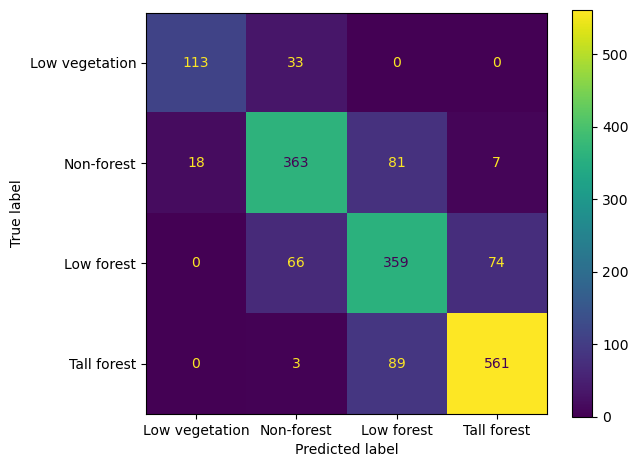

In [65]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.tight_layout()
# plt.savefig(r'figs4class\XGB_PS2_S2_S1_CM.png', dpi=600)
plt.show()

In [66]:
# Pretty labels for the feature importance chart. Only used for the final run.

new_index = [r'PS2 $\alpha$',
             r'PS2 $P_{u}$',
             r'PS2 $\gamma^{0}_{HV}$',
             r'Green',
             r'S1 $\alpha$',
             r'S1 $P_{u}$',
             r'Red-edge 1',
             r'PS2 DpRBI',
             r'S1 $P_{dl}$',
             r'Blue',
             r'PS2 $\gamma^{0}_{HH}$',
             r'S1 DpRBI',
             r'PS2 DpRSI',
             r'BSI',
             r'Red',
             r'PS2 $P_{dl}$',
             r'NIR 1',
             r'Red-edge 2',
             r'S1 $\gamma^{0}_{VH}$',
             r'NIR 2',
             r'Red-edge 3',
             r'EVI',
             r'NDVI',
             r'S1 DpRSI',
             r'PS2 $P_{sl}$',
             r'S1 $\gamma^{0}_{VV}$',
             r'S1 $P_{sl}$',
             r'PS2 $\gamma^{0}_{HV}\, /\, \gamma^{0}_{HH}$',
]

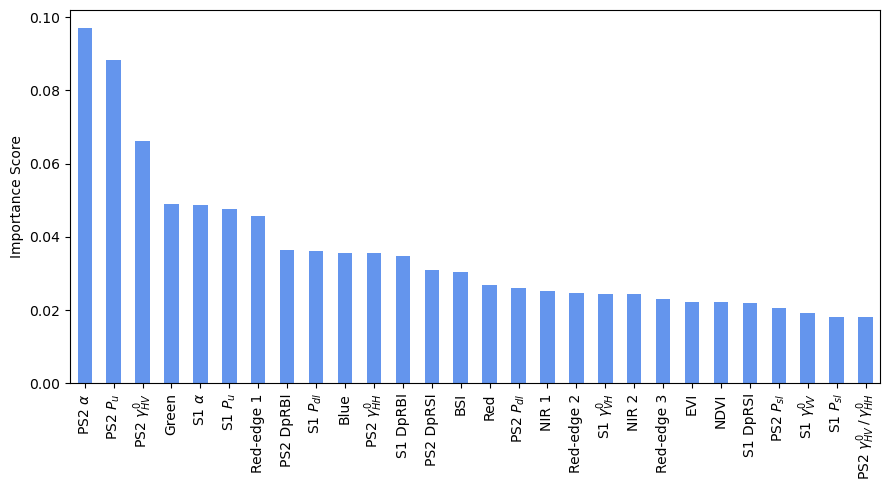

In [67]:
# Feature important chart. Uncomment f.index = new_index for pretty labels.
importances = final_model.feature_importances_
feature_importance_series = pd.Series(importances, index=X.columns[:-3])   # :-3 removes easting, zone, site id
f = feature_importance_series.sort_values(ascending=False)
f.index = new_index
plt.figure(figsize=(9, 5))
f.plot(kind='bar', color='cornflowerblue')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig(r'XGB_4class_PS2_S1_S2_Importance.png', dpi=600)

## Create the full prediction

In [68]:
data_stacked = data_stack.stack(sample=('y','x'))
X_full = data_stacked.transpose('sample', 'band')
X_full = X_full.dropna(how='any', dim='sample')
X_full_df = pd.DataFrame(X_full, columns = X.columns[:-3])

In [69]:
X_predict = final_model.predict(X_full_df)

In [70]:
pred_da = xr.DataArray(X_predict, coords={'sample': X_full.coords['sample']}, dims=['sample'])
empty_map = xr.full_like(data_stack.isel(band=0), fill_value=np.nan, dtype=np.float32)
classification_map = pred_da.unstack('sample')

In [71]:
# Use .combine_first() to place the classified pixels onto the empty map.
# This preserves any NaN values where there was no original data.
final_map = classification_map.combine_first(empty_map)

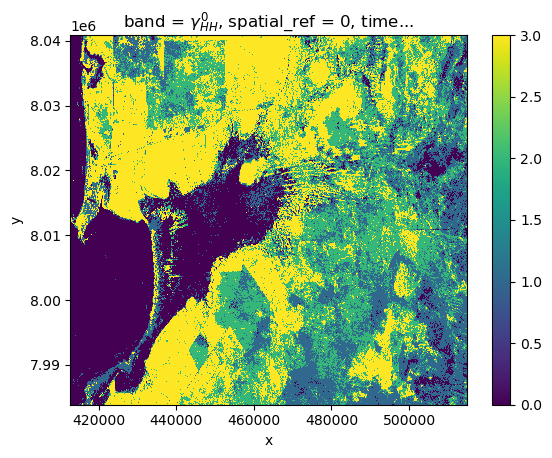

In [72]:
final_map.plot();
plt.show();

In [73]:
# final_map.rio.to_raster(r'figs4class\XGB_strat_PS2_S1_S2_4class.tif')